<a href="https://colab.research.google.com/github/nshaganti/Coding-Projects/blob/master/Analysis_Code_DID_SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/nshaganti/nshaganti-difference-in-differences-lp.git

Cloning into 'nshaganti-difference-in-differences-lp'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 1), reused 13 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 1.06 MiB | 2.71 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
import os
repo = 'nshaganti-difference-in-differences-lp'
if os.getcwd().split("/")[-1] == repo:
  print("Already in the correct directory")
else:
  os.chdir(repo)
  print(f"Changed working directory to: {repo}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
import graphviz as gr

warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

Changed working directory to: nshaganti-difference-in-differences-lp


In [ ]:
data = pd.read_csv("diff_in_diff.csv")

In [ ]:
data.shape

(50000, 8)

In [ ]:
data.head()

,sales,discount,age,gender,cust_state,tenure,profit,month
0,1153.28,0,25,O,MA,19,57.66,7
1,1978.13,0,26,M,MG,16,98.91,6
2,1095.70,0,26,W,RJ,20,54.78,2
3,2404.90,25,30,W,BA,18,95.24,6
4,1704.80,0,38,M,PB,15,85.24,4


In [ ]:
# understand the inferred data types
data.dtypes

,0
sales,float64
discount,int64
age,int64
gender,object
cust_state,object
tenure,int64
profit,float64
month,int64


In [ ]:
# check for any missing data
data.isna().sum()

,0
sales,0
discount,0
age,0
gender,4965
cust_state,0
tenure,0
profit,0
month,0


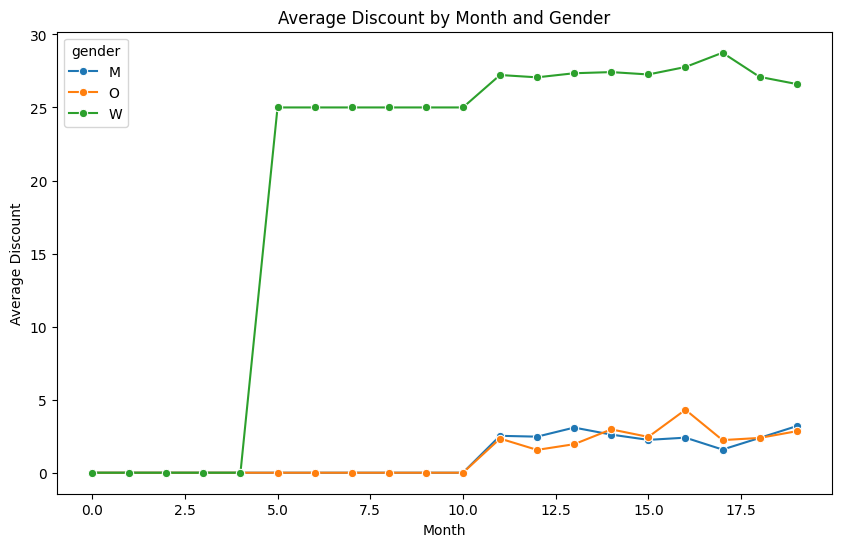

In [ ]:
# Group data by month and gender, then calculate the average discount
agg_discount = data.groupby(['month', 'gender'])['discount'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='discount', hue='gender', data=agg_discount, marker='o')
plt.title('Average Discount by Month and Gender')
plt.xlabel('Month')
plt.ylabel('Average Discount')
plt.show()

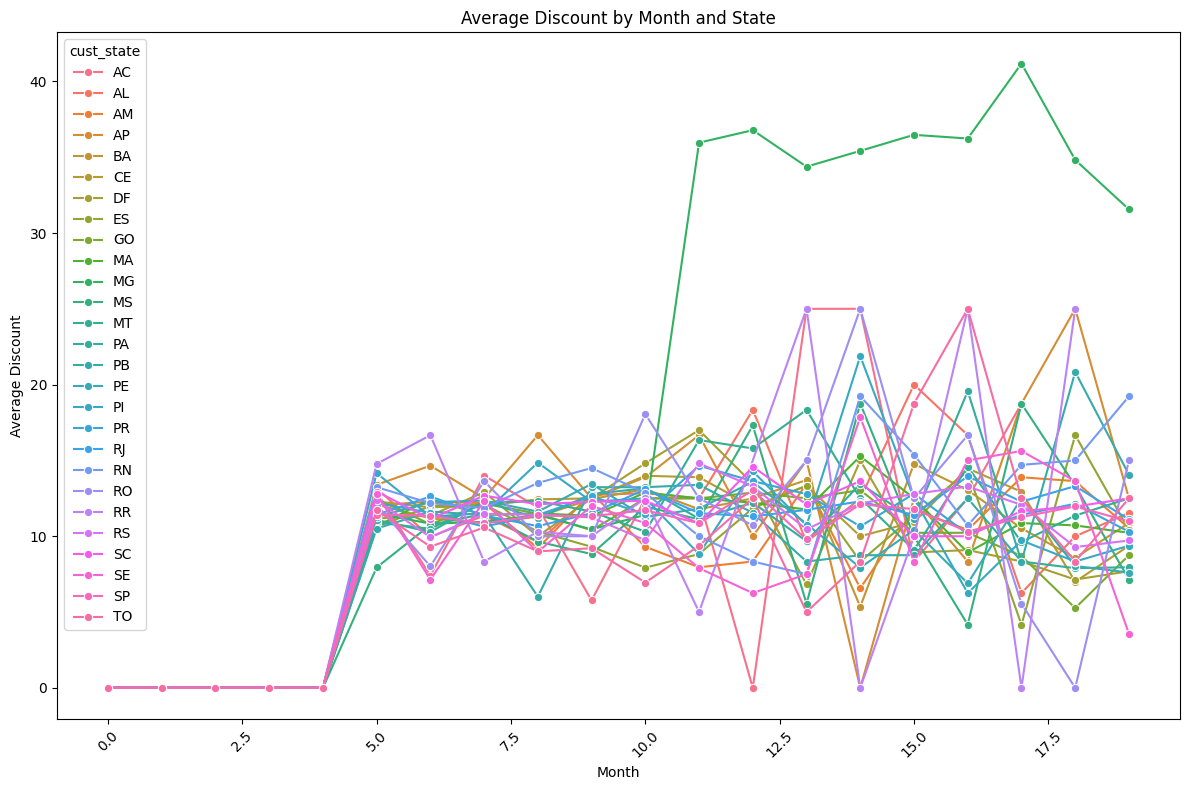

In [ ]:
# Group data by customer state and month
state_df = data.groupby(['cust_state', 'month'])[['profit', 'discount']].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(x='month', y='discount', hue='cust_state', data=state_df, marker='o')
plt.title('Average Discount by Month and State')
plt.xlabel('Month')
plt.ylabel('Average Discount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
data['post_intervention'] = data['month'] > 4
data['treated'] = (data['gender'] == 'W')

In [ ]:
avg_profit_before = data[(data['treated'] == True) & (data['month'] < 5)]['profit'].mean()
print(f"Average profit for treated group before intervention: {avg_profit_before}")

avg_profit_after = data[(data['treated'] == True) & (data['month'] >= 5)]['profit'].mean()
print(f"Average profit for treated group after intervention: {avg_profit_after}")

diff_profit = avg_profit_after - avg_profit_before
print(f"Difference in average profit: {diff_profit}")

Average profit for treated group before intervention: 78.17665787623065
Average profit for treated group after intervention: 85.31840415612095
Difference in average profit: 7.141746279890299


After the intervention period, the woman's profit increased by \$7.14. In other words

$$
E[Y|Gender=W, Period=1] - E[Y|Gender=W, Period=0] = 7.14
$$

We can interpret this as the average causal effect of the discount on profit **only if woman's profit is not changing with time**. That is, only if, if there were no discount (potential outcome 0), women's profit before and after the intervention were the same:

$$
E[Y_0|Gender=W, Period=1] = E[Y_0|Gender=W, Period=0]
$$

In [ ]:
avg_profit_control_after = data[(data['treated'] == False) & (data['month'] >= 5)]['profit'].mean()
print(f"Average profit for control group (men) after intervention: {avg_profit_control_after}")

# Difference in profits after the intervention between the treated and control group.
diff_profit_treatment_control = avg_profit_after - avg_profit_control_after
print(f"Difference in average profit between treated and control groups after intervention: {diff_profit_treatment_control}")

Average profit for control group (men) after intervention: 92.44278128831462
Difference in average profit between treated and control groups after intervention: -7.124377132193672


After the intervention period, the treated (woman's) profit is \$7.12 **lower** than the untreated (men) group. That is,

$$
E[Y|Gender=W, Period=1] - E[Y|Gender=NotW, Period=1] = -7.12
$$

We can interpret this as the average causal effect of the discount on profit **only if woman's would the same profit as men's if there were no discount for woman**.

$$
E[Y_0|Gender=W, Period=1] = E[Y_0|Gender=NotW, Period=1]
$$

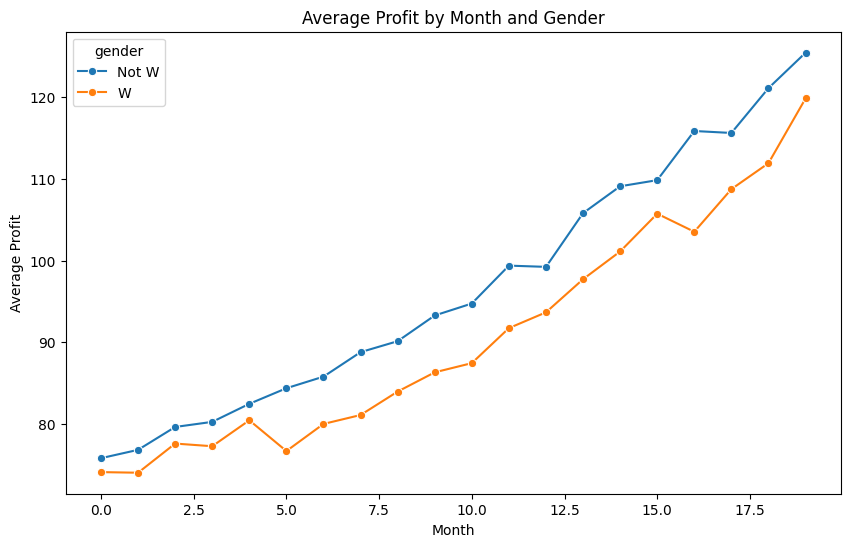

In [ ]:
data['gender'] = np.where(data['gender'] == 'W', 'W', 'Not W')

# Group data by month and gender, then calculate the average profit
agg_profit = data.groupby(['month', 'gender'])['profit'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='profit', hue='gender', data=agg_profit, marker='o')
plt.title('Average Profit by Month and Gender')
plt.xlabel('Month')
plt.ylabel('Average Profit')
plt.show()

Treated and control groups seem to have parallel trends, aside for when the intervention takes place (month 5). However, men's profit is overall higher than women's profit, so the assumption we made above in step 5 is probably not true. Also, women's profit seems to be increasing over time, so the assumption we made above is also probably not true.

In [ ]:
# Calculate the average profit for the control group before the intervention
avg_profit_control_before = data[(data['treated'] == False) & (data['month'] < 5)]['profit'].mean()
print(f"Average profit for control group before intervention: {avg_profit_control_before}")

# Difference-in-differences estimator
# Growth in the treated group
growth_treated = avg_profit_after - avg_profit_before

# Growth in the control group
avg_profit_control_after = data[(data['treated'] == False) & (data['month'] >= 5)]['profit'].mean()
growth_control = avg_profit_control_after - avg_profit_control_before

# Diff-in-diff estimator
diff_in_diff = growth_treated - growth_control

print(f"The impact of discounts on profits, according to diff in diff, is {diff_in_diff}.")

Average profit for control group before intervention: 80.5275333662877
The impact of discounts on profits, according to diff in diff, is -4.7735016421366225.


In [ ]:
# Create interaction term
data['interaction'] = data['treated'] * data['post_intervention']

# Regression
reg_diff_in_diff = smf.ols('profit ~ treated + post_intervention + interaction', data=data).fit()
print(reg_diff_in_diff.summary())

# Extract the interaction coefficient
interaction_coef = reg_diff_in_diff.params['interaction[T.True]']
print(f"\nThe value of the interaction coefficient is: {interaction_coef}")
print(f"\nThe diff-in-diff estimate was: {diff_in_diff}")

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     511.6
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        00:23:02   Log-Likelihood:            -2.4221e+05
No. Observations:               50000   AIC:                         4.844e+05
Df Residuals:                   49996   BIC:                         4.845e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

The interaction coefficient is numerically identical to the diff-in-diff estimator we've estimated by hand. This diff-in-diff estimator can be interpreted as the causal effect if men's and women's profit have similar growth trajectories (parallel trends). This is a much weaker assumption than the ones we've made above.

That is, if the treatment effect of giving \$25 in discount is -4.77, things are not looking good for the discount product. This means that, for every \$1.00 in discount, we expect to lose about \$0.20.

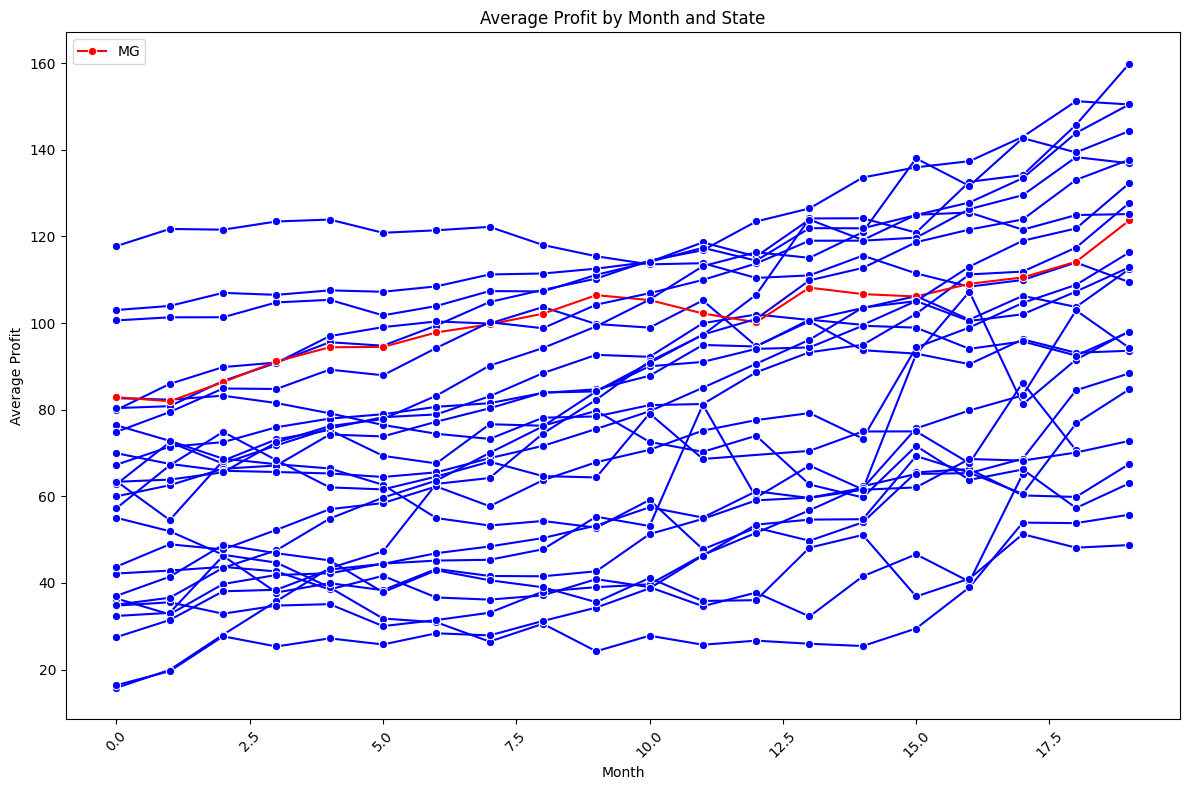

In [ ]:
plt.figure(figsize=(12, 8))
for state in state_df['cust_state'].unique():
    state_data = state_df[state_df['cust_state'] == state]
    if state == 'MG':
        sns.lineplot(x='month', y='profit', data=state_data, marker='o', label=state, color='red')
    else:
        sns.lineplot(x='month', y='profit', data=state_data, marker='o', color='blue')
plt.title('Average Profit by Month and State')
plt.xlabel('Month')
plt.ylabel('Average Profit')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [43]:
# Create preintervention data by month and state
intervention_data = data.groupby(['month', 'cust_state'])['profit'].mean().unstack().fillna(0)
preintervention_data  = intervention_data[intervention_data.index < 11]

In [45]:
from sklearn.linear_model import ElasticNet

X = preintervention_data.drop(columns=['MG'])
y = preintervention_data['MG']

model = ElasticNet(alpha=50, fit_intercept=False, max_iter=10000)
model.fit(X, y)

weights = model.coef_

Using ElasticNet, we can find weights such that we can build our synthetic control in a way that approximates the treated unit, MG, in the pre-intervention period.

$$
Profit_{mg} \approx \sum^S_{s=0} w_s * Profit_s
$$

We can even see which states we are combining to make our synthetic control. For instance we are only using states CE, DF, ES, ES, GO, PE, PR, RN, RS and SP in the combination. All other weights are zero.


In [47]:
reshaped_data = intervention_data.drop(columns=['MG'])
synthetic_control = np.dot(reshaped_data, weights)

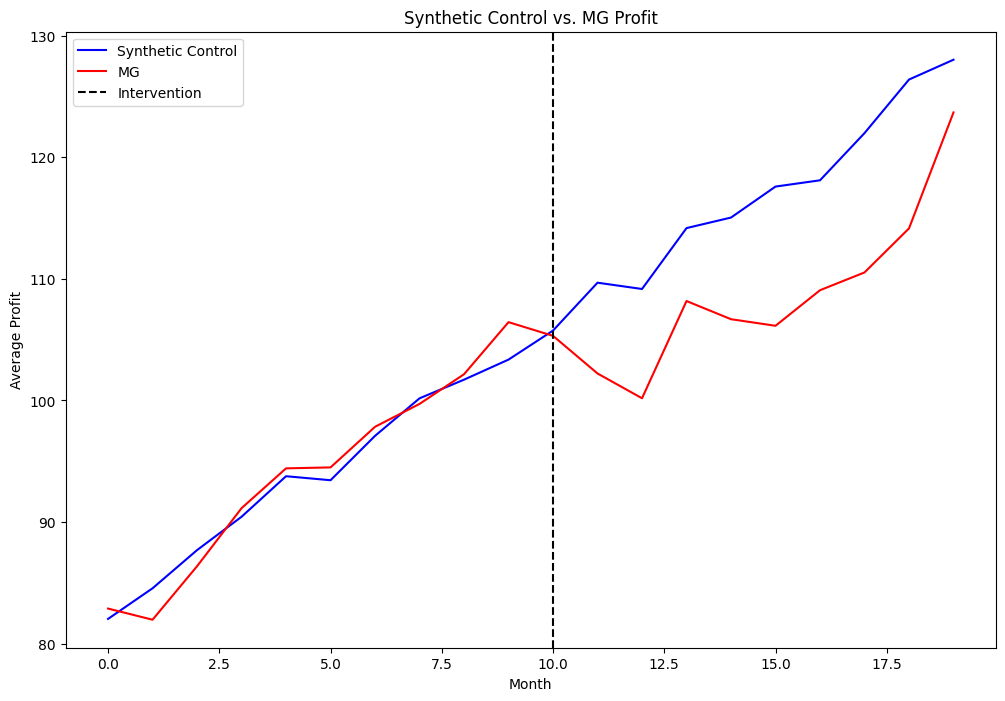

In [52]:
plt.figure(figsize=(12, 8))
plt.plot(intervention_data.index, synthetic_control, label='Synthetic Control', color='blue')
plt.plot(intervention_data.index, intervention_data['MG'], label='MG', color='red')
plt.axvline(x=10, color='black', linestyle='--', label='Intervention')
plt.title('Synthetic Control vs. MG Profit')
plt.xlabel('Month')
plt.ylabel('Average Profit')
plt.legend()
plt.show()

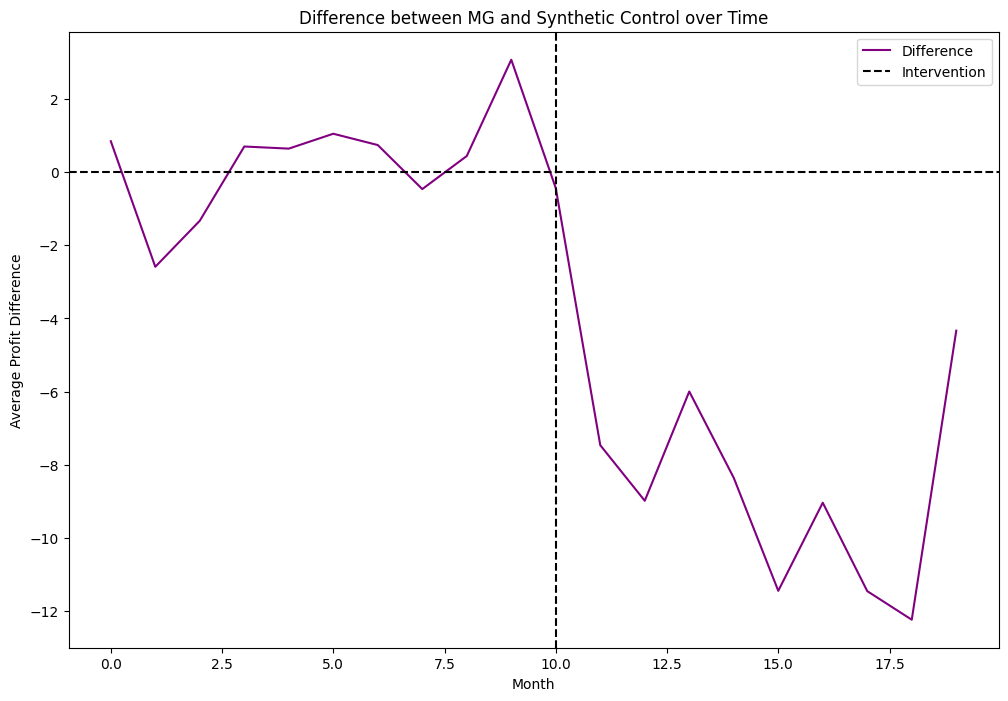

In [55]:
plt.figure(figsize=(12, 8))
plt.plot(intervention_data.index, intervention_data['MG'] - synthetic_control, label='Difference', color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.axvline(x=10, color='black', linestyle='--', label='Intervention')
plt.title('Difference between MG and Synthetic Control over Time')
plt.xlabel('Month')
plt.ylabel('Average Profit Difference')
plt.legend()
plt.show()

We can see that the profit of synthetic control keeps growing after the intervention, while the profit for the state of MG takes a dip. This means that, after increasing the discount, the state became less profitable.

If we plot the difference between them, we can see the effect of discounts on profits over time. Again, we conclude that the effect is negative, meaning that discount is not profitable.